## Background

R.S. says:
> Here are the details of the features: Five texture features (energy, entropy, correlation, homogeneity, and contrast) were extracted from T2-w using Haralick descriptors. The features were calculated using the gray-level co-occurrence matrices (GLCM) for each voxel underlying the contoured regions in the image. Voxel-wise texture measures were computed in 28 directions by sliding a window of size 5 × 5 × 5 across the image region enclosing the tumor volume. First, image intensities were rescaled within 0 to 256 range using the entire image. The GLCM was then computed in 3-D using 128 bins in a 5 × 5 × 5 patch centered at each voxel. The texture values for the whole tumor were then summarized using the voxel-wise textures. Nine histogram descriptors (10%, 25%, mean, median, 75%, 90%, stdev, skewness, kurtosis) described above were calculated for each texture feature.

## Initialization

In [1]:
from radiomics import firstorder, shape, glcm
import os, sys
import numpy as np
import SimpleITK as sitk
import pandas as pd

def normalizedImage(image):
    im_arr = sitk.GetArrayFromImage(image).astype(float)    
    print("Intensity range: ", np.min(im_arr), np.max(im_arr))
    im_arr += np.min(im_arr)
    im_arr *= 256 / np.max(im_arr)
    im = sitk.GetImageFromArray(im_arr.astype(int))
    im.CopyInformation(image)
    return im

def getTexture(image,mask,features):
    settings = {"voxelBased": True, "kernelRadius": 2, "binCount": 128}
    gf = glcm.RadiomicsGLCM(image, mask, **settings)
    for f in features:
        gf.enableFeatureByName(f, True)
    return gf.execute()
    
filePrefix = "../cleanedUp"
firstOrderFeatures = [("10","10Percentile"),       # QG58
                      ("90","90Percentile"),       # 8DWT
                      ("mean", "Mean"),            # Q4LE
                      ("SD", "StandardDeviation"), # 
                      ("Kur", "Kurtosis"),         # IPH6 - 3
                      ("Ske", "Skewness"),         # KE2A
                      ("50","Median")              # Y12H
                     ]
shapeFeatures = [("ROI_Vol", "VoxelVolume")]
                 
#                 "t2_int_25", "t2_int_50", "t2_int_mean", \
#"t2_int_75",  , , , "t2_con_10"]

usfFeatures = pd.read_csv(os.path.join(filePrefix,"Challenge_training_T2w.csv"),sep=",")
#####


In [2]:
usfFeatureNames = [f for f in usfFeatures.columns if f.startswith("t2")]
#usfFeatureNames

## Variables

In [15]:
imageFiles = ["subject0000.nrrd","subject0001.nrrd"]
subjects = ["0000", "0001","0015","0026","0055"]
maskTypes = ["T_PZ", "F_TZ","T_TZ","T_TZ","T_TZ"]
#maskFileSuffixes = ["subject0000 ROI-1_T_PZ.nrrd", "subject0001 ROI-1_F_TZ.nrrd"]

usfValues = []
prValues = []
subjectValues = []
featureTypes = []

## Make feature images

In [17]:
# generate texture maps
textureNames = [("int", "original"),    # original image
                ("con","Contrast"),     # ACUI
                ("cor","Correlation"),  # NI2N
                ("ene","JointEnergy"),  # 8ZQL
                ("ent","JointEntropy"), # TU9B
                ("hom","Idmn")          # WF0Z
               ]
pyrTextureNames = [i for (_,i) in textureNames if i != "original"]
inputImages = {}
inputMasks = {}
for (i,s) in enumerate(subjects):
    
    fullSubjectID = "ProstateX-"+s
    print("\nProcessing Subject "+fullSubjectID)

    imageFile = os.path.join(filePrefix, "subject%s.nrrd" % s)
    maskFile = os.path.join(filePrefix, "subject%s ROI-1_%s.nrrd" % (s, maskTypes[i]))
    image = sitk.ReadImage(imageFile)

    mask = sitk.ReadImage(maskFile)
    ma_arr = sitk.GetArrayFromImage(mask)
    print("Number of voxels in the mask: "+str(np.sum(ma_arr == 1)))

    sf = shape.RadiomicsShape(image, mask)
    sf.enableFeatureByName('VoxelVolume', True)
    print("Mask volume: pyradiomics:"+str(sf.execute()["VoxelVolume"]/1000.)+" / USF: "+str(usfFeatures[usfFeatures["Patient"]==fullSubjectID]['ROI_Vol'].values[0]))
    
    inputMasks[s] = mask
    
    textureMapsPerSubject = getTexture(normalizedImage(image), mask, pyrTextureNames)
    for (_,tn) in textureNames:
        if tn == "original":
            inputImages[s] = [image]
        else:
            inputImages[s].append(normalizedImage(textureMapsPerSubject[tn]))


Processing Subject ProstateX-0000
Number of voxels in the mask: 1770
Mask volume: pyradiomics:1.3275009495019925 / USF: 1.3275
Intensity range:  0.0 1118.0
Intensity range:  0.0 2267.17094988345
Intensity range:  -0.5884242620285078 0.5070356444599216
Intensity range:  0.0 0.3632109375
Intensity range:  0.0 7.050530384408341
Intensity range:  0.0 0.996071058652392

Processing Subject ProstateX-0001
Number of voxels in the mask: 484
Mask volume: pyradiomics:0.363000259637833 / USF: 0.3915
Intensity range:  0.0 1118.0
Intensity range:  0.0 876.2363436883627
Intensity range:  -0.598782534145074 0.34991650998041857
Intensity range:  0.0 0.39817768467266695
Intensity range:  0.0 6.322168571434607
Intensity range:  0.0 0.9980549886260227

Processing Subject ProstateX-0015
Number of voxels in the mask: 8851
Mask volume: pyradiomics:6.638253692924979 / USF: 6.63825
Intensity range:  0.0 1153.0
Intensity range:  0.0 2335.9382151981226
Intensity range:  -0.5792867717482624 0.7046363195045395
In

## Original image features

In [18]:
resultsFrame = pd.DataFrame(columns=["Subject","FeatureSource", "FeatureName", "FeatureValue"])


In [19]:
subjectsList = []
featureSourcesList = []
featureNamesList = []
featureValuesList = []

for (subjectI,subject) in enumerate(subjects):
    fullSubjectID = "ProstateX-"+subject
    
    for (imageI,image) in enumerate(inputImages[subject]):

        usfPrefix = "t2_"+textureNames[imageI][0]
        
        fof = firstorder.RadiomicsFirstOrder(image, inputMasks[subject])
        for (_,prName) in firstOrderFeatures:
            fof.enableFeatureByName(prName, True)
        prResults = fof.execute()    

        for (usfName,prName) in firstOrderFeatures:
            usfName = usfPrefix+"_"+usfName
            usfValue = usfFeatures[usfFeatures["Patient"]==fullSubjectID][usfName].values[0]
            
            # add USF feature
            subjectsList.append(fullSubjectID)
            featureSourcesList.append("USF")
            featureNamesList.append(usfName)
            featureValuesList.append(usfValue)
            
            # add pyradiomics feature
            subjectsList.append(fullSubjectID)
            featureSourcesList.append("pyradiomics")
            featureNamesList.append(usfName)
            featureValuesList.append(prResults[prName])
            if prName == "Kurtosis":
                featureValuesList[-1] = featureValuesList[-1]-3.
                
resultsFrame["Subject"] = subjectsList
resultsFrame["FeatureSource"] = featureSourcesList
resultsFrame["FeatureName"] = featureNamesList
resultsFrame["FeatureValue"] = featureValuesList

Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with cautio

In [31]:
resultsFrame.to_csv("USF_feature_comparison.csv")

## Make plots

ProstateX-0000
2073.0


/Users/fedorov/.pyenv/versions/3.5.3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


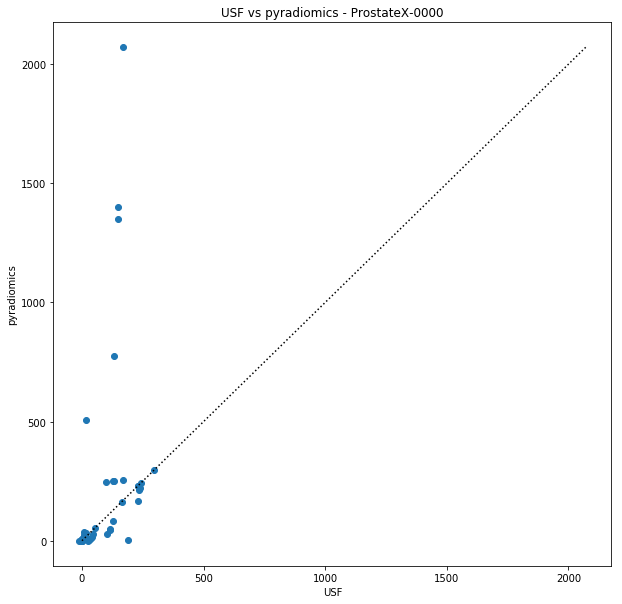

ProstateX-0001
794.8


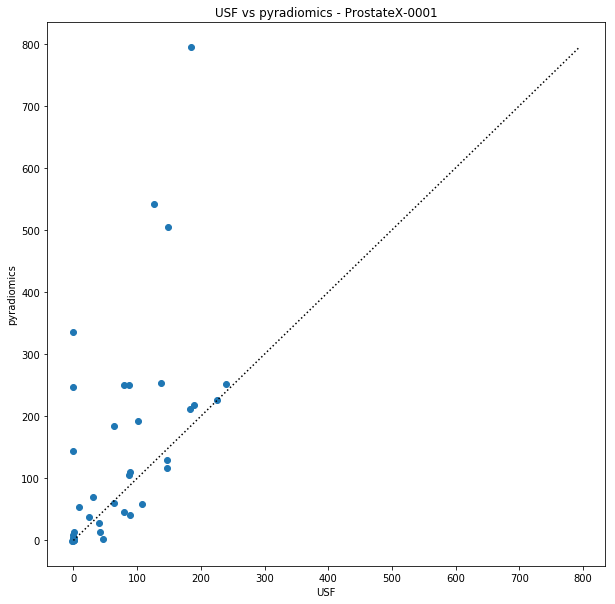

ProstateX-0015
273.0


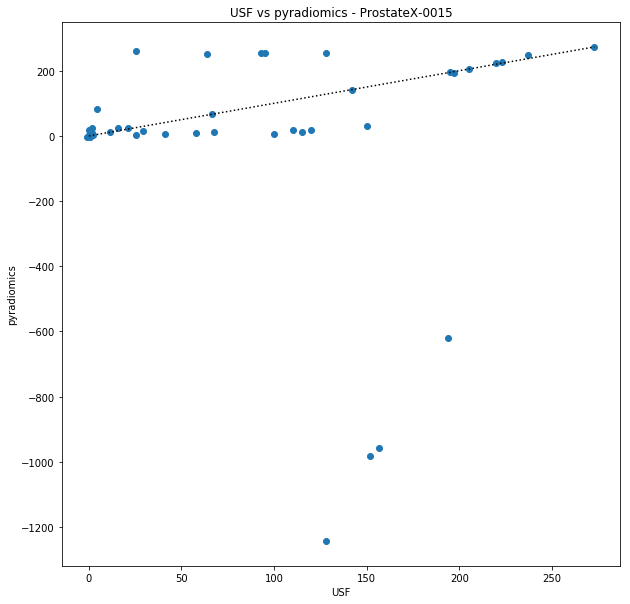

ProstateX-0026
4194.5


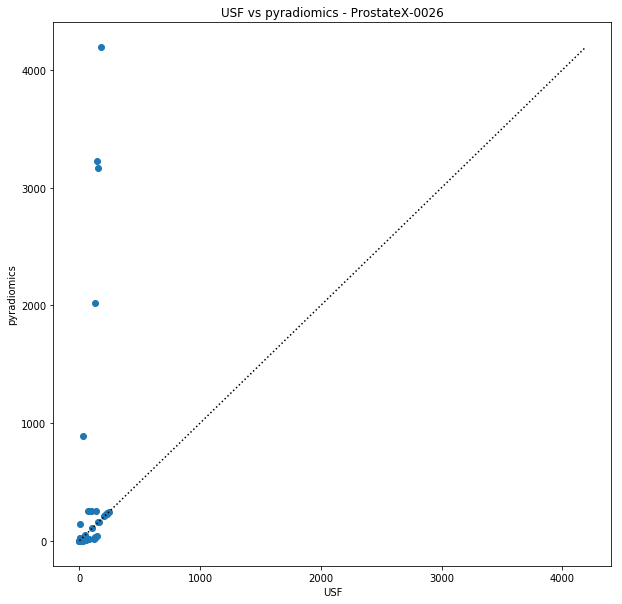

ProstateX-0055
3274.7000000000007


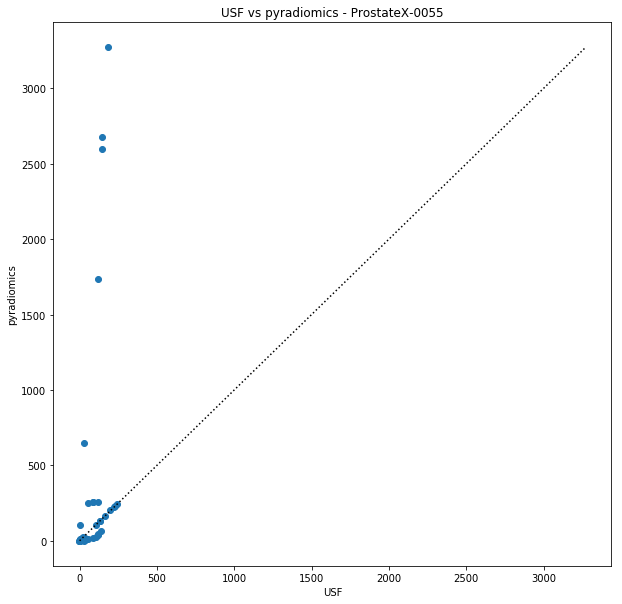

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 


for (subjectI,subject) in enumerate(subjects):

    # Plot
    subjectName = "ProstateX-"+subject
    print(subjectName)
    subjectSubset = resultsFrame[resultsFrame["Subject"]==subjectName]
    
    # subset specific features class
    #subjectSubset = subjectSubset[subjectSubset['FeatureName'].str.match('t2_ene_')]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    x = subjectSubset[subjectSubset["FeatureSource"]=="USF"]["FeatureValue"].values
    y = subjectSubset[subjectSubset["FeatureSource"]=="pyradiomics"]["FeatureValue"].values

    maxF=np.max([np.max(x),np.max(y)])
    print(maxF)
    annotations = subjectSubset[resultsFrame["FeatureSource"]=="USF"]["FeatureName"].values

    ax.scatter(x,y)
    ax.plot([0,maxF],[0,maxF],c='black',linestyle=':')

    plt.title('USF vs pyradiomics - '+subjectName)
    plt.xlabel('USF')
    plt.ylabel('pyradiomics')


    #for (i,annotation) in enumerate(annotations):
    #    ax.annotate(annotation,xy=(x[i],y[i]),rotation=45)

    plt.show()
    
    fig.savefig(subjectName+".png", bbox_inches='tight')

#plt.scatter(usfValues[6:], prValues[6:], c=subjectValues[6:])
#plt.title('USF vs pyradiomics')
#plt.xlabel('USF')
#plt.ylabel('pyradiomics')
#plt.show()